# Training Probes using Contrast-Consistent Search (CCS)

This notebook demonstrates how to train probes using the CCS approach from Burns et al. (2023). CCS is a method for learning probes that can extract beliefs from language models without using labeled data.

The key idea is to train a probe that:
1. Makes informative predictions (assigns high probabilities to at least one of the contrast pairs)
2. Makes consistent predictions (assigns complementary probabilities to contrast pairs)

For example, if we have a statement "The sky is blue", we create two contrast pairs:
- "The sky is blue" (positive)
- "The sky is not blue" (negative)

The probe should assign high probability to one of these and low probability to the other.

In [8]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn
import torch.nn.functional as F
import copy

/Users/ruijiacao/Documents/Ruijia/Research/eliciting_beliefs_llm/eliciting_beliefs_ai/.conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
class LoadModel:
    def __init__(self, model_name: str, layer_idx: int, token_pos: int, device: str = "cuda" if torch.cuda.is_available() else "cpu"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True).to(device)
        self.model.eval()
        self.layer_idx = layer_idx
        self.token_pos = token_pos
        self.device = device

    def extract_activation(self, text: str):
        inputs = self.tokenizer(text, return_tensors="pt").to(self.device)
        
        with torch.no_grad():
            outputs = self.model(**inputs)
        
        hidden_states = outputs.hidden_states  # tuple: (embeddings, layer1, layer2, ..., final layer)

        if self.layer_idx >= len(hidden_states):
            raise ValueError(f"Layer index {self.layer_idx} is out of range.")
        
        activation = hidden_states[self.layer_idx]  # (batch_size, seq_len, hidden_dim)
        
        # Often we take the activation at the final token
        activation = activation[:, self.token_pos, :]  # shape: (batch_size, hidden_dim)

        return activation.squeeze(0).cpu()  # Return a 1D numpy array
    

In [13]:
class MLPProbe(nn.Module):
    """
    This a two-layer MLP for a potential non-linear probe
    """
    def __init__(self, d):
        super().__init__()
        self.linear1 = nn.Linear(d, 100)
        self.linear2 = nn.Linear(100, 1)

    def forward(self, x):
        h = F.relu(self.linear1(x))
        o = self.linear2(h)
        return torch.sigmoid(o)

class CCS(object):
    def __init__(self, x0, x1, nepochs=1000, ntries=10, lr=1e-3, batch_size=-1, 
                 verbose=False, device="cpu", linear=True, weight_decay=0.01, var_normalize=False):
        # data
        self.var_normalize = var_normalize
        self.x0 = self.normalize(x0)
        self.x1 = self.normalize(x1)
        self.d = self.x0.shape[-1]

        # training
        self.nepochs = nepochs
        self.ntries = ntries
        self.lr = lr
        self.verbose = verbose
        self.device = device
        self.batch_size = batch_size
        self.weight_decay = weight_decay
        
        # probe
        self.linear = linear
        self.initialize_probe()
        self.best_probe = copy.deepcopy(self.probe)

        
    def initialize_probe(self):
        if self.linear:
            self.probe = nn.Sequential(nn.Linear(self.d, 1), nn.Sigmoid())
        else:
            self.probe = MLPProbe(self.d)
        self.probe.to(self.device)    


    def normalize(self, x):
        """
        Mean-normalizes the data x (of shape (n, d))
        If self.var_normalize, also divides by the standard deviation
        """
        normalized_x = x - x.mean(axis=0, keepdims=True)
        if self.var_normalize:
            normalized_x /= normalized_x.std(axis=0, keepdims=True)

        return normalized_x

        
    def get_tensor_data(self):
        """
        Returns x0, x1 as appropriate tensors (rather than np arrays)
        """
        x0 = torch.tensor(self.x0, dtype=torch.float, requires_grad=False, device=self.device)
        x1 = torch.tensor(self.x1, dtype=torch.float, requires_grad=False, device=self.device)
        return x0, x1
    

    def get_loss(self, p0, p1):
        """
        Returns the CCS loss for two probabilities each of shape (n,1) or (n,)
        """
        informative_loss = (torch.min(p0, p1)**2).mean(0)
        consistent_loss = ((p0 - (1-p1))**2).mean(0)
        return informative_loss + consistent_loss


    def get_acc(self, x0_test, x1_test, y_test):
        """
        Computes accuracy for the current parameters on the given test inputs
        """
        x0 = torch.tensor(self.normalize(x0_test), dtype=torch.float, requires_grad=False, device=self.device)
        x1 = torch.tensor(self.normalize(x1_test), dtype=torch.float, requires_grad=False, device=self.device)
        with torch.no_grad():
            p0, p1 = self.best_probe(x0), self.best_probe(x1)
        avg_confidence = 0.5*(p0 + (1-p1))
        predictions = (avg_confidence.detach().cpu().numpy() < 0.5).astype(int)[:, 0]
        acc = (predictions == y_test).mean()
        acc = max(acc, 1 - acc)

        return acc
    
        
    def train(self):
        """
        Does a single training run of nepochs epochs
        """
        x0, x1 = self.get_tensor_data()
        permutation = torch.randperm(len(x0))
        x0, x1 = x0[permutation], x1[permutation]
        
        # set up optimizer
        optimizer = torch.optim.AdamW(self.probe.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        
        batch_size = len(x0) if self.batch_size == -1 else self.batch_size
        nbatches = len(x0) // batch_size

        # Start training (full batch)
        for epoch in range(self.nepochs):
            for j in range(nbatches):
                x0_batch = x0[j*batch_size:(j+1)*batch_size]
                x1_batch = x1[j*batch_size:(j+1)*batch_size]
            
                # probe
                p0, p1 = self.probe(x0_batch), self.probe(x1_batch)

                # get the corresponding loss
                loss = self.get_loss(p0, p1)

                # update the parameters
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return loss.detach().cpu().item()
    
    def repeated_train(self):
        best_loss = np.inf
        for train_num in range(self.ntries):
            self.initialize_probe()
            loss = self.train()
            if loss < best_loss:
                self.best_probe = copy.deepcopy(self.probe)
                best_loss = loss

        return best_loss

### Example Usage

In [4]:
model_name = "meta-llama/Llama-3.2-1B-Instruct"  # Replace with your model
layer_idx = -2  # Example layer
token_pos = -1

trainer = LoadModel(model_name, layer_idx, token_pos)

### Example Usage

In [5]:
positive_texts = ["Captial of France is Paris"]
negative_texts = ["Captial of France is not Paris"]
positive_tests = [
    "Captial of China is not Beijing"
    "Captial of USA is Washington D.C.."
]

negative_tests = [
    "Captial of China is Beijing",
    "Captial of USA is not Washington D.C.."
]
pos_hs_train = torch.stack([trainer.extract_activation(text) for text in positive_texts]) 
neg_hs_train = torch.stack([trainer.extract_activation(text) for text in negative_texts])

pos_hs_test = torch.stack([trainer.extract_activation(text) for text in positive_tests]) 
neg_hs_test = torch.stack([trainer.extract_activation(text) for text in negative_tests])

In [6]:
# Train CCS without any labels
ccs = CCS(neg_hs_train, pos_hs_train)
ccs.repeated_train()
probe = ccs.best_probe
# print(probe.type)
y_test = [0, 1]

# Evaluate
ccs_acc = ccs.get_acc(neg_hs_test, pos_hs_test, y_test)
print("CCS accuracy: {}".format(ccs_acc))

/var/folders/pc/wyw5y57d1pg63jf5nqv55_lc0000gq/T/ipykernel_25271/3652077333.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(self.x0, dtype=torch.float, requires_grad=False, device=self.device)
/var/folders/pc/wyw5y57d1pg63jf5nqv55_lc0000gq/T/ipykernel_25271/3652077333.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x1 = torch.tensor(self.x1, dtype=torch.float, requires_grad=False, device=self.device)


<bound method Module.type of Sequential(
  (0): Linear(in_features=2048, out_features=1, bias=True)
  (1): Sigmoid()
)>
CCS accuracy: 1.0


/var/folders/pc/wyw5y57d1pg63jf5nqv55_lc0000gq/T/ipykernel_25271/3652077333.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(self.normalize(x0_test), dtype=torch.float, requires_grad=False, device=self.device)
/var/folders/pc/wyw5y57d1pg63jf5nqv55_lc0000gq/T/ipykernel_25271/3652077333.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x1 = torch.tensor(self.normalize(x1_test), dtype=torch.float, requires_grad=False, device=self.device)


### Testing

In [6]:
#CCS on cities.csv
#set the directory to the location of your data
import pandas as pd
import os

In [7]:
datapath = "../datasets"
df_cities = pd.read_csv(os.path.join(datapath, "cities.csv"))
df_cities.head()

,statement,label,city,country,correct_country
0,The city of Krasnodar is in Russia.,1,Krasnodar,Russia,Russia
1,The city of Krasnodar is in South Africa.,0,Krasnodar,South Africa,Russia
2,The city of Lodz is in Poland.,1,Lodz,Poland,Poland
3,The city of Lodz is in the Dominican Republic.,0,Lodz,the Dominican Republic,Poland
4,The city of Maracay is in Venezuela.,1,Maracay,Venezuela,Venezuela


In [21]:
# Split into positive and negative statement lists
positive_statements = df_cities[df_cities['label'] == 1]['statement'].tolist()
negative_statements = df_cities[df_cities['label'] == 0]['statement'].tolist()

print(f"Positive examples: {len(positive_statements)}")
print(f"Negative examples: {len(negative_statements)}")

Positive examples: 748
Negative examples: 748


In [25]:
from tqdm import tqdm

#  Extract hidden states for positives and negatives with a progress bar
pos_hs_cities = torch.stack([
    trainer.extract_activation(text) for text in tqdm(positive_statements, desc="Extracting Positive Activations")
])

neg_hs_cities = torch.stack([
    trainer.extract_activation(text) for text in tqdm(negative_statements, desc="Extracting Negative Activations")
])

print(f"Positive activations shape: {pos_hs_cities.shape}")
print(f"Negative activations shape: {neg_hs_cities.shape}")


Extracting Positive Activations:   0%|          | 0/748 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Extracting Negative Activations: 100%|██████████| 748/748 [07:39<00:00,  1.63it/s]

Positive activations shape: torch.Size([748, 2048])
Negative activations shape: torch.Size([748, 2048])


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(



🔵 Layer 0/15


Positive activations:   0%|          | 0/748 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Negative activations: 100%|██████████| 748/748 [08:08<00:00,  1.53it/s]


CCS acc: 1.0000 | LR acc: 0.5000

🔵 Layer 1/15


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Negative activations: 100%|██████████| 748/748 [07:52<00:00,  1.58it/s]


CCS acc: 0.5067 | LR acc: 0.5167

🔵 Layer 2/15


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Negative activations: 100%|██████████| 748/748 [07:50<00:00,  1.59it/s]


CCS acc: 0.5067 | LR acc: 0.4867

🔵 Layer 3/15


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Negative activations: 100%|██████████| 748/748 [07:49<00:00,  1.59it/s]


CCS acc: 0.5000 | LR acc: 0.5800

🔵 Layer 4/15


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Negative activations: 100%|██████████| 748/748 [07:41<00:00,  1.62it/s]


CCS acc: 0.5200 | LR acc: 0.7100

🔵 Layer 5/15


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Negative activations: 100%|██████████| 748/748 [07:48<00:00,  1.60it/s]


CCS acc: 0.5467 | LR acc: 0.8700

🔵 Layer 6/15


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Negative activations: 100%|██████████| 748/748 [07:39<00:00,  1.63it/s]


CCS acc: 0.5067 | LR acc: 0.8867

🔵 Layer 7/15


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Negative activations: 100%|██████████| 748/748 [09:38<00:00,  1.29it/s]  


CCS acc: 0.5400 | LR acc: 0.9600

🔵 Layer 8/15


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Negative activations: 100%|██████████| 748/748 [07:53<00:00,  1.58it/s]


CCS acc: 0.5267 | LR acc: 0.9833

🔵 Layer 9/15


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Negative activations: 100%|██████████| 748/748 [07:43<00:00,  1.61it/s]


CCS acc: 0.5133 | LR acc: 0.9767

🔵 Layer 10/15


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Negative activations: 100%|██████████| 748/748 [07:26<00:00,  1.67it/s]


CCS acc: 0.5267 | LR acc: 0.9800

🔵 Layer 11/15


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Negative activations: 100%|██████████| 748/748 [07:35<00:00,  1.64it/s]


CCS acc: 0.5067 | LR acc: 0.9800

🔵 Layer 12/15


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Negative activations: 100%|██████████| 748/748 [49:19<00:00,  3.96s/it]    


CCS acc: 0.5000 | LR acc: 0.9800

🔵 Layer 13/15


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Negative activations: 100%|██████████| 748/748 [39:00<00:00,  3.13s/it]    


CCS acc: 0.5000 | LR acc: 0.9733

🔵 Layer 14/15


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Negative activations: 100%|██████████| 748/748 [41:08<00:00,  3.30s/it]    


CCS acc: 0.5267 | LR acc: 0.9700

🔵 Layer 15/15


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Negative activations: 100%|██████████| 748/748 [37:32<00:00,  3.01s/it]    


CCS acc: 0.5333 | LR acc: 0.9700

Results saved to 'ccs_lr_layerwise_results.csv'
Probes saved to 'saved_probes.pt'


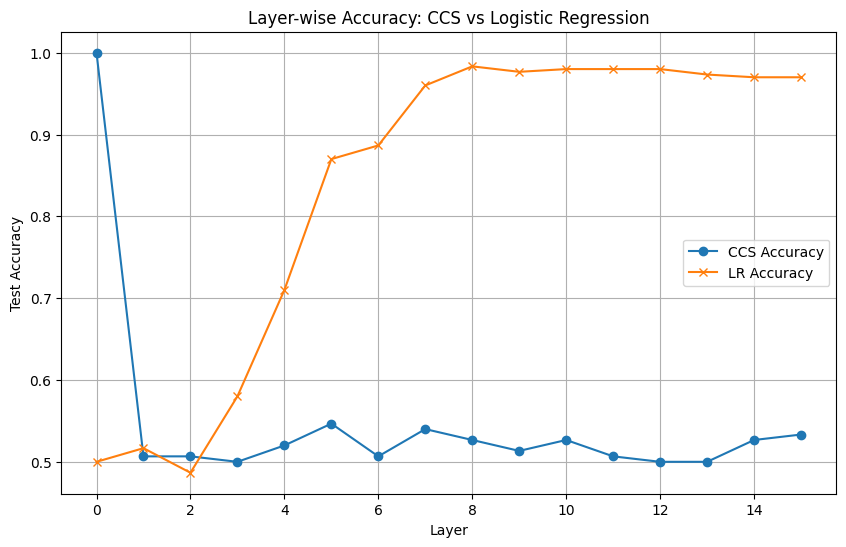


 Accuracy plot saved to 'ccs_lr_accuracy_plot.png'


In [7]:
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt

def randomize(x0: np.ndarray, x1: np.ndarray):
    """Shuffle positives and negatives together, then split (not used here but kept)."""
    X = np.vstack([x0, x1])
    y = np.array([1]*len(x0) + [0]*len(x1))
    perm = np.random.permutation(len(X))
    X, y = X[perm], y[perm]
    return X[y == 1], X[y == 0]

DATA_PATH = "../datasets/cities.csv"   # adjust as needed
df = pd.read_csv(DATA_PATH)

positive_statements = df[df.label == 1]["statement"].tolist()
negative_statements = df[df.label == 0]["statement"].tolist()

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "meta-llama/Llama-3.2-1B-Instruct"
token_pos = -1  

tmp = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
num_layers = tmp.config.num_hidden_layers
del tmp

results = {"layer": [], "ccs_accuracy": [], "lr_accuracy": []}
all_probes = []  # for saving W, b

for layer_idx in range(num_layers):
    print(f"\n🔵 Layer {layer_idx}/{num_layers-1}")

    #  extract activations at this layer
    loader = LoadModel(model_name, layer_idx, token_pos, device)
    
    pos_hs = torch.stack([
        loader.extract_activation(t) for t in tqdm(positive_statements, desc="Positive activations")
    ]).numpy()
    
    neg_hs = torch.stack([
        loader.extract_activation(t) for t in tqdm(negative_statements, desc="Negative activations")
    ]).numpy()

    #  combine
    X_all = np.vstack([pos_hs, neg_hs])
    y_all = np.array([1]*len(pos_hs) + [0]*len(neg_hs))

    #  train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_all, y_all, test_size=0.2, stratify=y_all, random_state=10
    )

    # split train/test into positives and negatives
    x0_train = X_train[y_train == 1]
    x1_train = X_train[y_train == 0]
    x0_test  = X_test[y_test == 1]
    x1_test  = X_test[y_test == 0]

    # train CCS
    ccs = CCS(x0_train, x1_train, nepochs=1000, ntries=5, lr=1e-3, device=device)
    ccs.repeated_train()

    y_dummy = np.zeros(len(x0_test))
    acc_ccs = ccs.get_acc(x0_test, x1_test, y_dummy)

    #  save CCS probe (W, b)
    probe = ccs.best_probe
    W = probe[0].weight.data.cpu().clone()
    b = probe[0].bias.data.cpu().clone()

    probe_data = {
        "W": W,
        "b": b,
        "token_position": token_pos,
        "layer_index": layer_idx,
        "linear": ccs.linear
    }
    all_probes.append(probe_data)

    #  train Logistic Regression
    X_lr = np.vstack([x0_train, x1_train])
    y_lr = np.array([1]*len(x0_train) + [0]*len(x1_train))
    clf = LogisticRegression(class_weight="balanced", max_iter=1000)
    clf.fit(X_lr, y_lr)
    acc_lr = clf.score(X_test, y_test)

    # record results
    results["layer"].append(layer_idx)
    results["ccs_accuracy"].append(acc_ccs)
    results["lr_accuracy"].append(acc_lr)

    print(f"CCS acc: {acc_ccs:.4f} | LR acc: {acc_lr:.4f}")

# 9. Save results
results_df = pd.DataFrame(results)
results_df.to_csv("ccs_lr_layerwise_results.csv", index=False)
print("\nResults saved to 'ccs_lr_layerwise_results.csv'")

# 10. Save probes
torch.save(all_probes, "saved_probes.pt")
print("Probes saved to 'saved_probes.pt'")

# 11. Plot CCS vs LR Accuracy
plt.figure(figsize=(10,6))
plt.plot(results["layer"], results["ccs_accuracy"], label="CCS Accuracy", marker="o")
plt.plot(results["layer"], results["lr_accuracy"], label="LR Accuracy", marker="x")
plt.xlabel("Layer")
plt.ylabel("Test Accuracy")
plt.title("Layer-wise Accuracy: CCS vs Logistic Regression")
plt.legend()
plt.grid(True)
plt.savefig("ccs_lr_accuracy_plot.png", dpi=300)
plt.show()

print("\n Accuracy plot saved to 'ccs_lr_accuracy_plot.png'")
